In [1]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

## Load LLM

In [2]:
import torch
from transformers import (
    LlamaForCausalLM, 
    AutoTokenizer
)

### Quantization

In [3]:
from transformers import BitsAndBytesConfig

In [5]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type= "nf4"
 )

In [4]:
tokenizer = AutoTokenizer.from_pretrained(
    "/home/gpaolo/nas_2/huggingface/hub/models--meta-llama--Meta-Llama-3-8B/snapshots/62bd457b6fe961a42a631306577e622c83876cb6/",
    # "/home/abenechehab/hugguingface/models--HuggingFaceTB--SmolLM-360M/snapshots/59f7ef243ee09a72cbc14cb054393a3e3b771d41",
    # "/home/abenechehab/hugguingface/models--google--gemma-2b/snapshots/68e273d91b1d6ea57c9e6024c4f887832f7b43fa",
    # "/home/gpaolo/nas_2/huggingface/hub/models--princeton-nlp--Sheared-LLaMA-1.3B/snapshots/a4b76938edbf571ea7d7d9904861cbdca08809b4/",
    # use_fast=False,
)
print(f"finish loading tokenizer")
model = LlamaForCausalLM.from_pretrained(
    "/home/gpaolo/nas_2/huggingface/hub/models--meta-llama--Meta-Llama-3-8B/snapshots/62bd457b6fe961a42a631306577e622c83876cb6/",
    # "/home/abenechehab/hugguingface/models--HuggingFaceTB--SmolLM-360M/snapshots/59f7ef243ee09a72cbc14cb054393a3e3b771d41",
    # "/home/abenechehab/hugguingface/models--google--gemma-2b/snapshots/68e273d91b1d6ea57c9e6024c4f887832f7b43fa",
    # "/home/gpaolo/nas_2/huggingface/hub/models--princeton-nlp--Sheared-LLaMA-1.3B/snapshots/a4b76938edbf571ea7d7d9904861cbdca08809b4/",
    device_map="auto",   
    # torch_dtype=torch.bfloat16, 
    # quantization_config=quantization_config
)
print(f"finish loading model")
# model.eval()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


finish loading tokenizer


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

finish loading model


### accelerate with torch compile

In [5]:
# model.forward = torch.compile(model.forward, mode="reduce-overhead", fullgraph=True)
# throwing an error for now

## Generate time series

In [5]:
from llmicl.rl_helpers.rl_utils import load_offline_dataset, create_env

/home/abenechehab/miniconda3/envs/LLMICL/lib/python3.9/site-packages/glfw/__init__.py:914: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)


In [22]:
env_name = 'HalfCheetah'
context_length = 300
dataset = 'expert'  # 'expert_80k_20k'
episode = 5

_, n_observations, n_actions = create_env(env_name)

data_path = f"/home/abenechehab/datasets/{env_name}/{dataset}/X_test.csv"
X = load_offline_dataset(path=data_path)

# find episodes beginnings
restart_index = n_observations+n_actions+1
restarts = X[:, restart_index]
episode_starts = np.where(restarts)[0]

print(f"episode starts: {episode_starts}")

init_index = episode_starts[episode]

time_series = X[init_index:init_index+context_length, :n_observations]

episode starts: [    0     1     2 ... 18997 18998 18999]


/home/abenechehab/miniconda3/envs/LLMICL/lib/python3.9/site-packages/gymnasium/envs/registration.py:521: UserWarning: WARN: Using the latest versioned environment `HalfCheetah-v4` instead of the unversioned environment `HalfCheetah`.
  logger.warn(


## Define Trainer and ICL

In [23]:
import gymnasium as gym
from llmicl.interfaces import trainers  # import RLICLTrainer

import importlib
importlib.reload(trainers)

<module 'llmicl.interfaces.trainers' from '/home/abenechehab/llmicl/src/llmicl/interfaces/trainers.py'>

In [24]:
%%time

rescale_factor = 7.0
up_shift = 1.5

trainer = trainers.RLICLTrainer(
    model=model,
    tokenizer=tokenizer,
    n_observations=n_observations,
    n_actions=n_actions,
    rescale_factor=rescale_factor,
    up_shift=up_shift,
)

trainer.update_context(
    time_series=copy.copy(time_series), 
    mean_series=copy.copy(time_series),
    sigma_series=np.zeros_like(time_series),
    context_length=context_length,
    update_min_max=True,
)
trainer.icl(
    verbose=1,
    llama_3_tokenizer=True,
    stochastic=True
)
icl_object = trainer.compute_statistics()

icl / state dim: 100%|███████████████████████████████████████████████████████████████████████████████████| 17/17 [00:15<00:00,  1.07it/s]
/home/abenechehab/llmicl/src/llmicl/interfaces/trainers.py:498: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2))))
/home/abenechehab/llmicl/src/llmicl/legacy/models/ICL.py:563: RuntimeWarning: divide by zero encountered in log
  log_ratio = np.log(self.bin_height_arr) - np.log(Multi_PDF.bin_height_arr)
/home/abenechehab/llmicl/src/llmicl/legacy/models/ICL.py:564: RuntimeWarning: invalid value encountered in multiply
  weighted_log_ratio = log_ratio * self.bin_height_arr * self.bin_width_arr


CPU times: user 15.5 s, sys: 1.89 s, total: 17.4 s
Wall time: 18.1 s


## Visualize

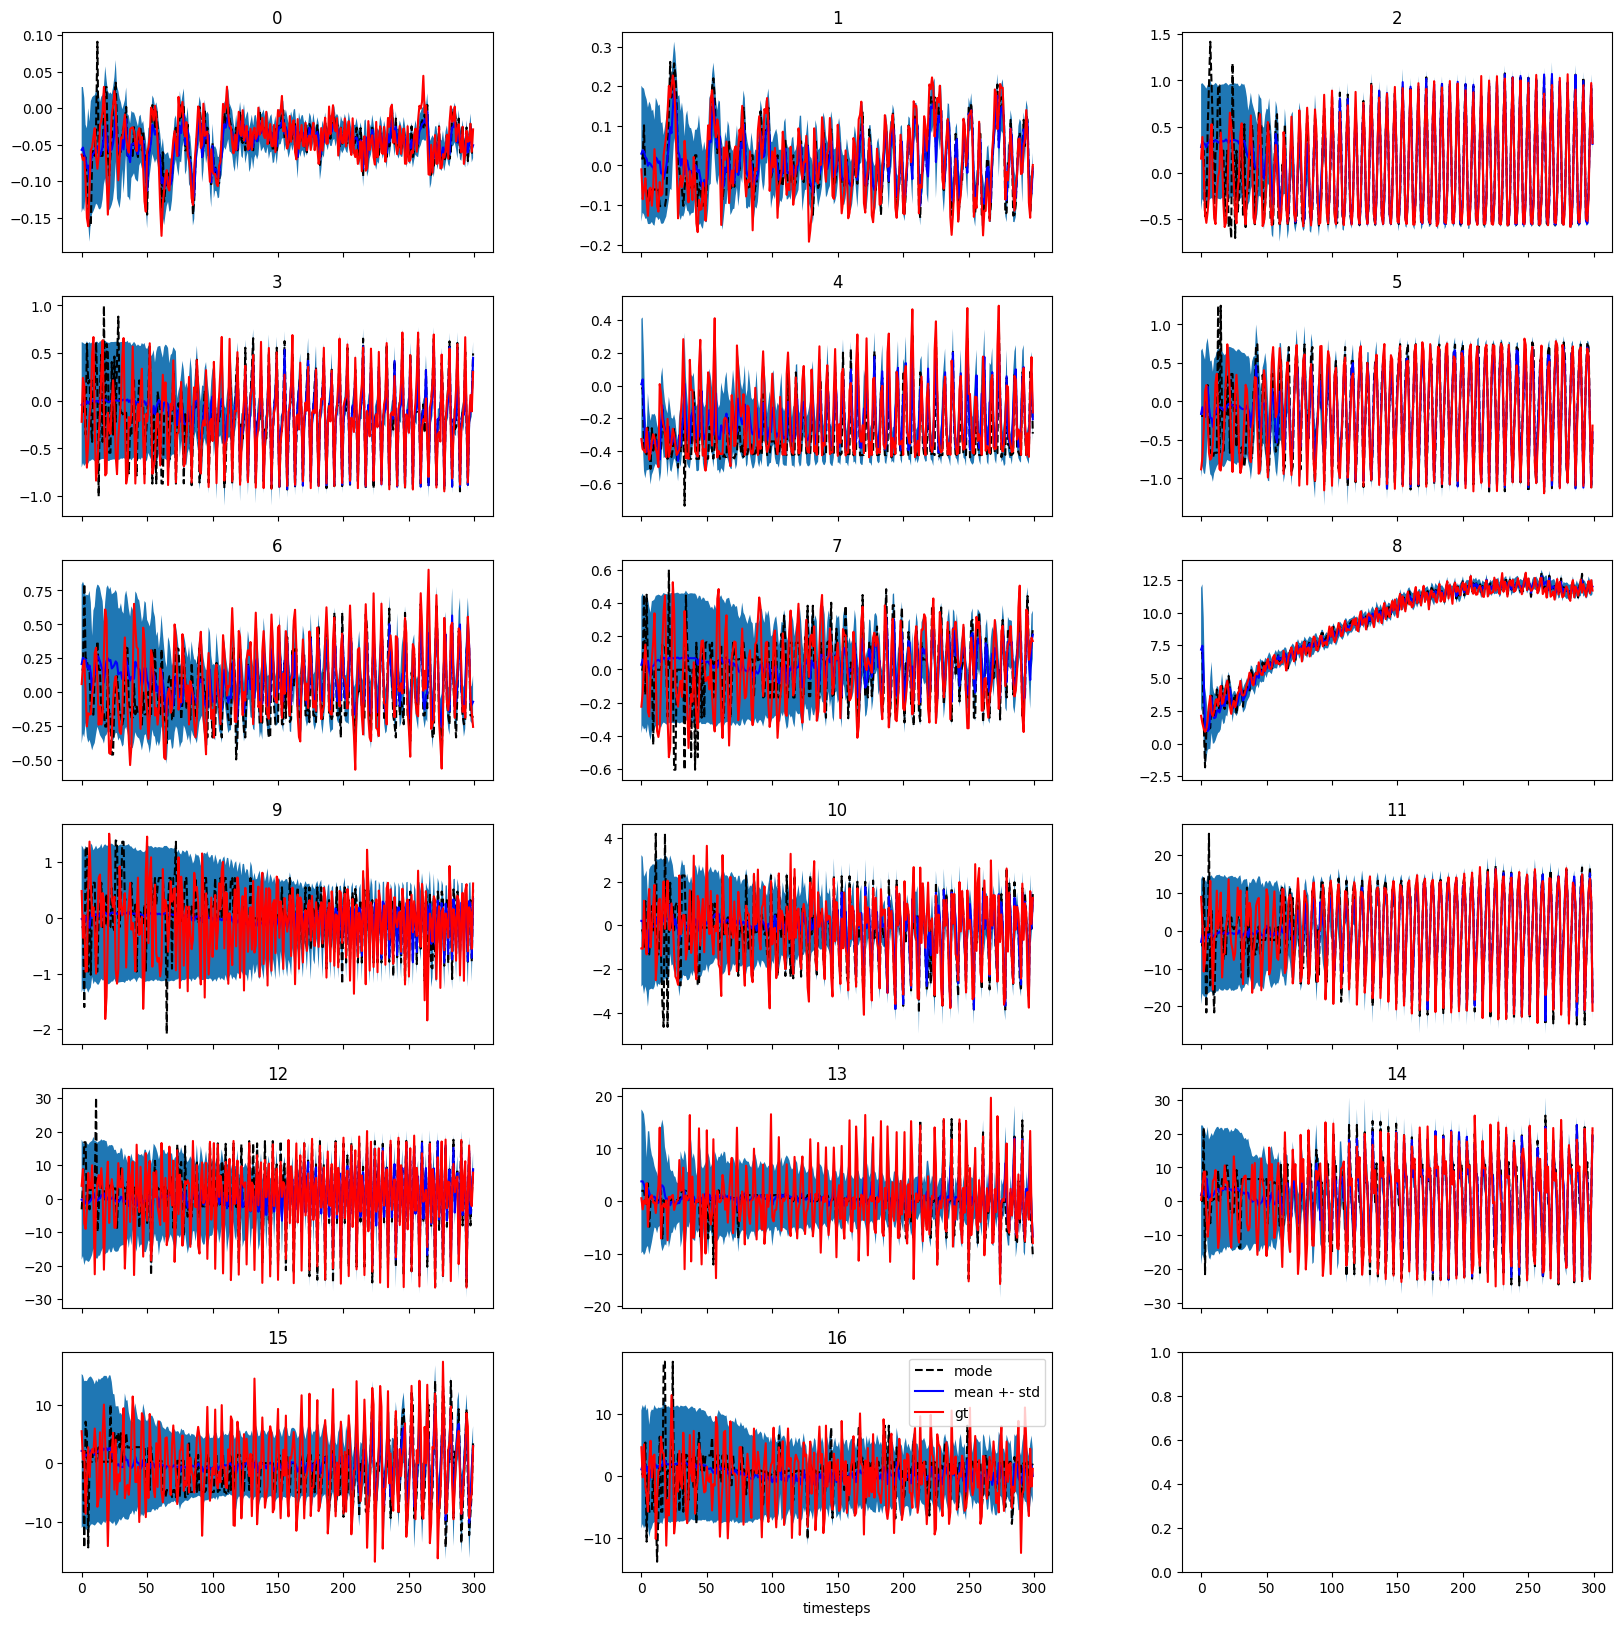

In [25]:
f, axes = plt.subplots(6, 3, figsize=(20, 20), gridspec_kw={'wspace':0.3}, sharex=True)
axes = list(np.array(axes).flatten())
for dim in range(n_observations):
    groundtruth = X[init_index+1:init_index+context_length+1, dim].flatten()
    
    ts_max = icl_object[dim].rescaling_max
    ts_min = icl_object[dim].rescaling_min
    # -------------------- Useful for Plots --------------------
    mode_arr = ((icl_object[dim].mode_arr.flatten() - up_shift) / rescale_factor) * (ts_max - ts_min) + ts_min 
    mean_arr = ((icl_object[dim].mean_arr.flatten() - up_shift) / rescale_factor) * (ts_max - ts_min) + ts_min
    sigma_arr = (icl_object[dim].sigma_arr.flatten() / rescale_factor) * (ts_max - ts_min)

    # -------------------- Trajectory visualization --------------------
    x = np.arange(mean_arr.shape[0])

    axes[dim].plot(x, mode_arr, 'k--',label='mode')
    axes[dim].plot(x, mean_arr, label='mean +- std', color='blue')
    axes[dim].fill_between(x=x, y1=mean_arr-sigma_arr, y2=mean_arr+sigma_arr)
    axes[dim].plot(x, groundtruth, label='gt', color='red')
    axes[dim].set_title(f"{dim}")
    if dim > 15:
        axes[dim].set_xlabel("timesteps")
axes[dim].legend()
# plt.savefig(f"RL_figures/traj_{columns[feature] if all_dim else columns[dim]}_{policy}.png")
plt.show()

## ICL parallel

In [26]:
%%time

rescale_factor = 7.0
up_shift = 1.5

trainer = trainers.RLICLTrainer(
    model=model,
    tokenizer=tokenizer,
    n_observations=n_observations,
    n_actions=n_actions,
    rescale_factor=rescale_factor,
    up_shift=up_shift,
)

trainer.update_context(
    time_series=copy.copy(time_series), 
    mean_series=copy.copy(time_series),
    sigma_series=np.zeros_like(time_series),
    context_length=context_length,
    update_min_max=True,
)
trainer.icl_parallel(
    verbose=1,
    stochastic=True
)
icl_object = trainer.compute_statistics()

icl / state dim: 100%|███████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 48.30it/s]


CPU times: user 11 s, sys: 4.8 s, total: 15.8 s
Wall time: 15.7 s


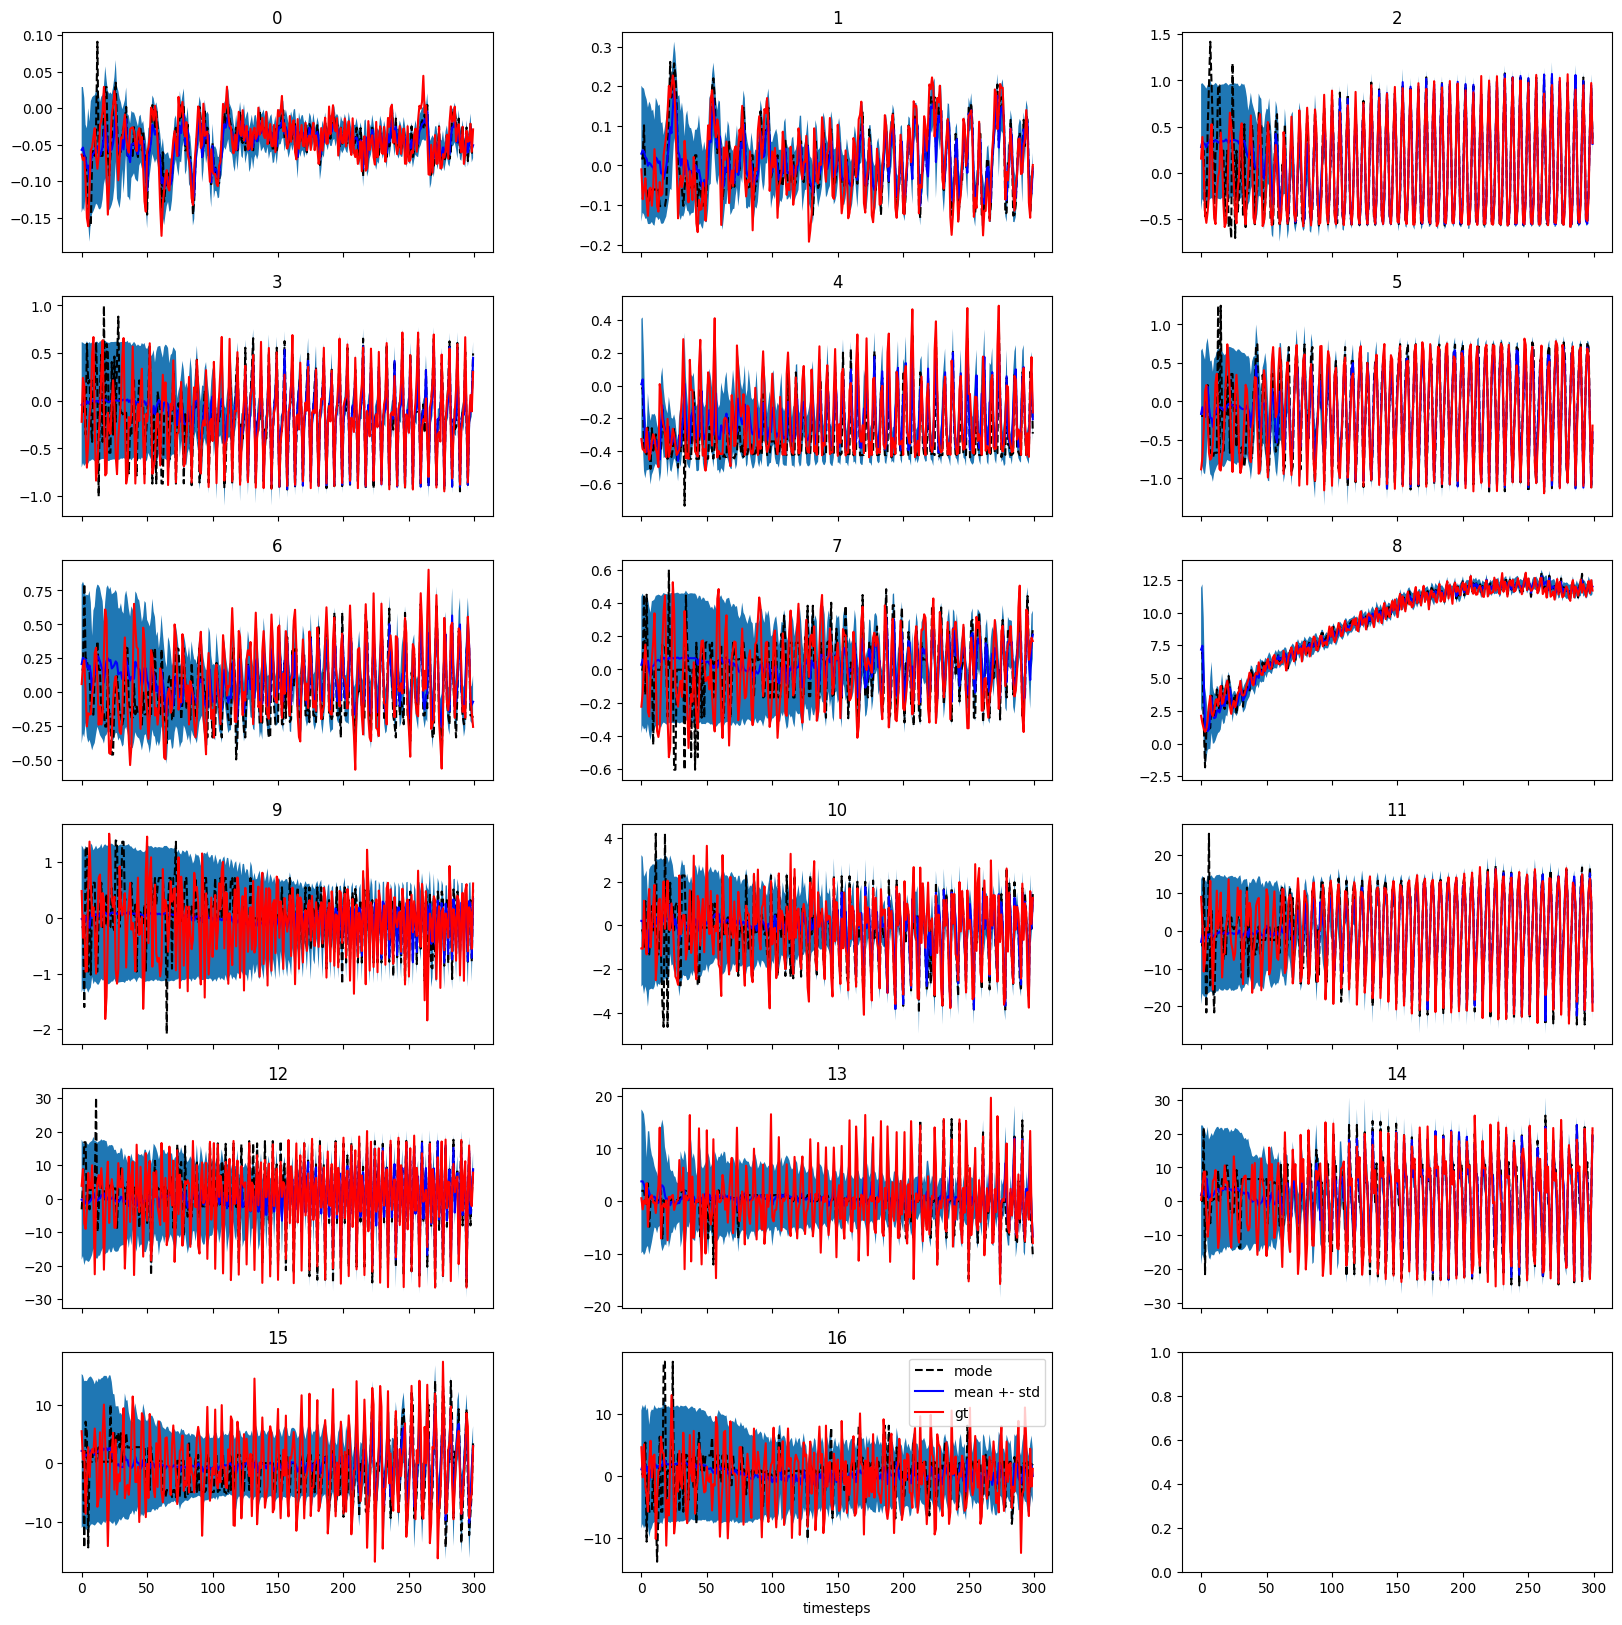

In [27]:
f, axes = plt.subplots(6, 3, figsize=(20, 20), gridspec_kw={'wspace':0.3}, sharex=True)
axes = list(np.array(axes).flatten())
for dim in range(n_observations):
    groundtruth = X[init_index+1:init_index+context_length+1, dim].flatten()
    
    ts_max = icl_object[dim].rescaling_max
    ts_min = icl_object[dim].rescaling_min
    # -------------------- Useful for Plots --------------------
    mode_arr = ((icl_object[dim].mode_arr.flatten() - up_shift) / rescale_factor) * (ts_max - ts_min) + ts_min 
    mean_arr = ((icl_object[dim].mean_arr.flatten() - up_shift) / rescale_factor) * (ts_max - ts_min) + ts_min
    sigma_arr = (icl_object[dim].sigma_arr.flatten() / rescale_factor) * (ts_max - ts_min)

    # -------------------- Trajectory visualization --------------------
    x = np.arange(mean_arr.shape[0])

    axes[dim].plot(x, mode_arr, 'k--',label='mode')
    axes[dim].plot(x, mean_arr, label='mean +- std', color='blue')
    axes[dim].fill_between(x=x, y1=mean_arr-sigma_arr, y2=mean_arr+sigma_arr)
    axes[dim].plot(x, groundtruth, label='gt', color='red')
    axes[dim].set_title(f"{dim}")
    if dim > 15:
        axes[dim].set_xlabel("timesteps")
axes[dim].legend()
# plt.savefig(f"RL_figures/traj_{columns[feature] if all_dim else columns[dim]}_{policy}.png")
plt.show()

## Multi-step prediction using the llm

In [11]:
prediction_horizon = 2

# recreate the trainer
trainer = trainers.RLICLTrainer(
    model=model,
    tokenizer=tokenizer,
    n_observations=n_observations,
    n_actions=n_actions,
    rescale_factor=rescale_factor,
    up_shift=up_shift,
)

trainer.update_context(
    time_series=copy.copy(time_series), 
    mean_series=copy.copy(time_series),
    sigma_series=np.zeros_like(time_series),
    context_length=context_length,
    update_min_max=True,
)
trainer.icl(verbose=1, stochastic=True)

icl_object = trainer.predict_long_horizon_llm(prediction_horizon=prediction_horizon, stochastic=True)

prediction_horizon: 100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:37<00:00, 18.64s/it]


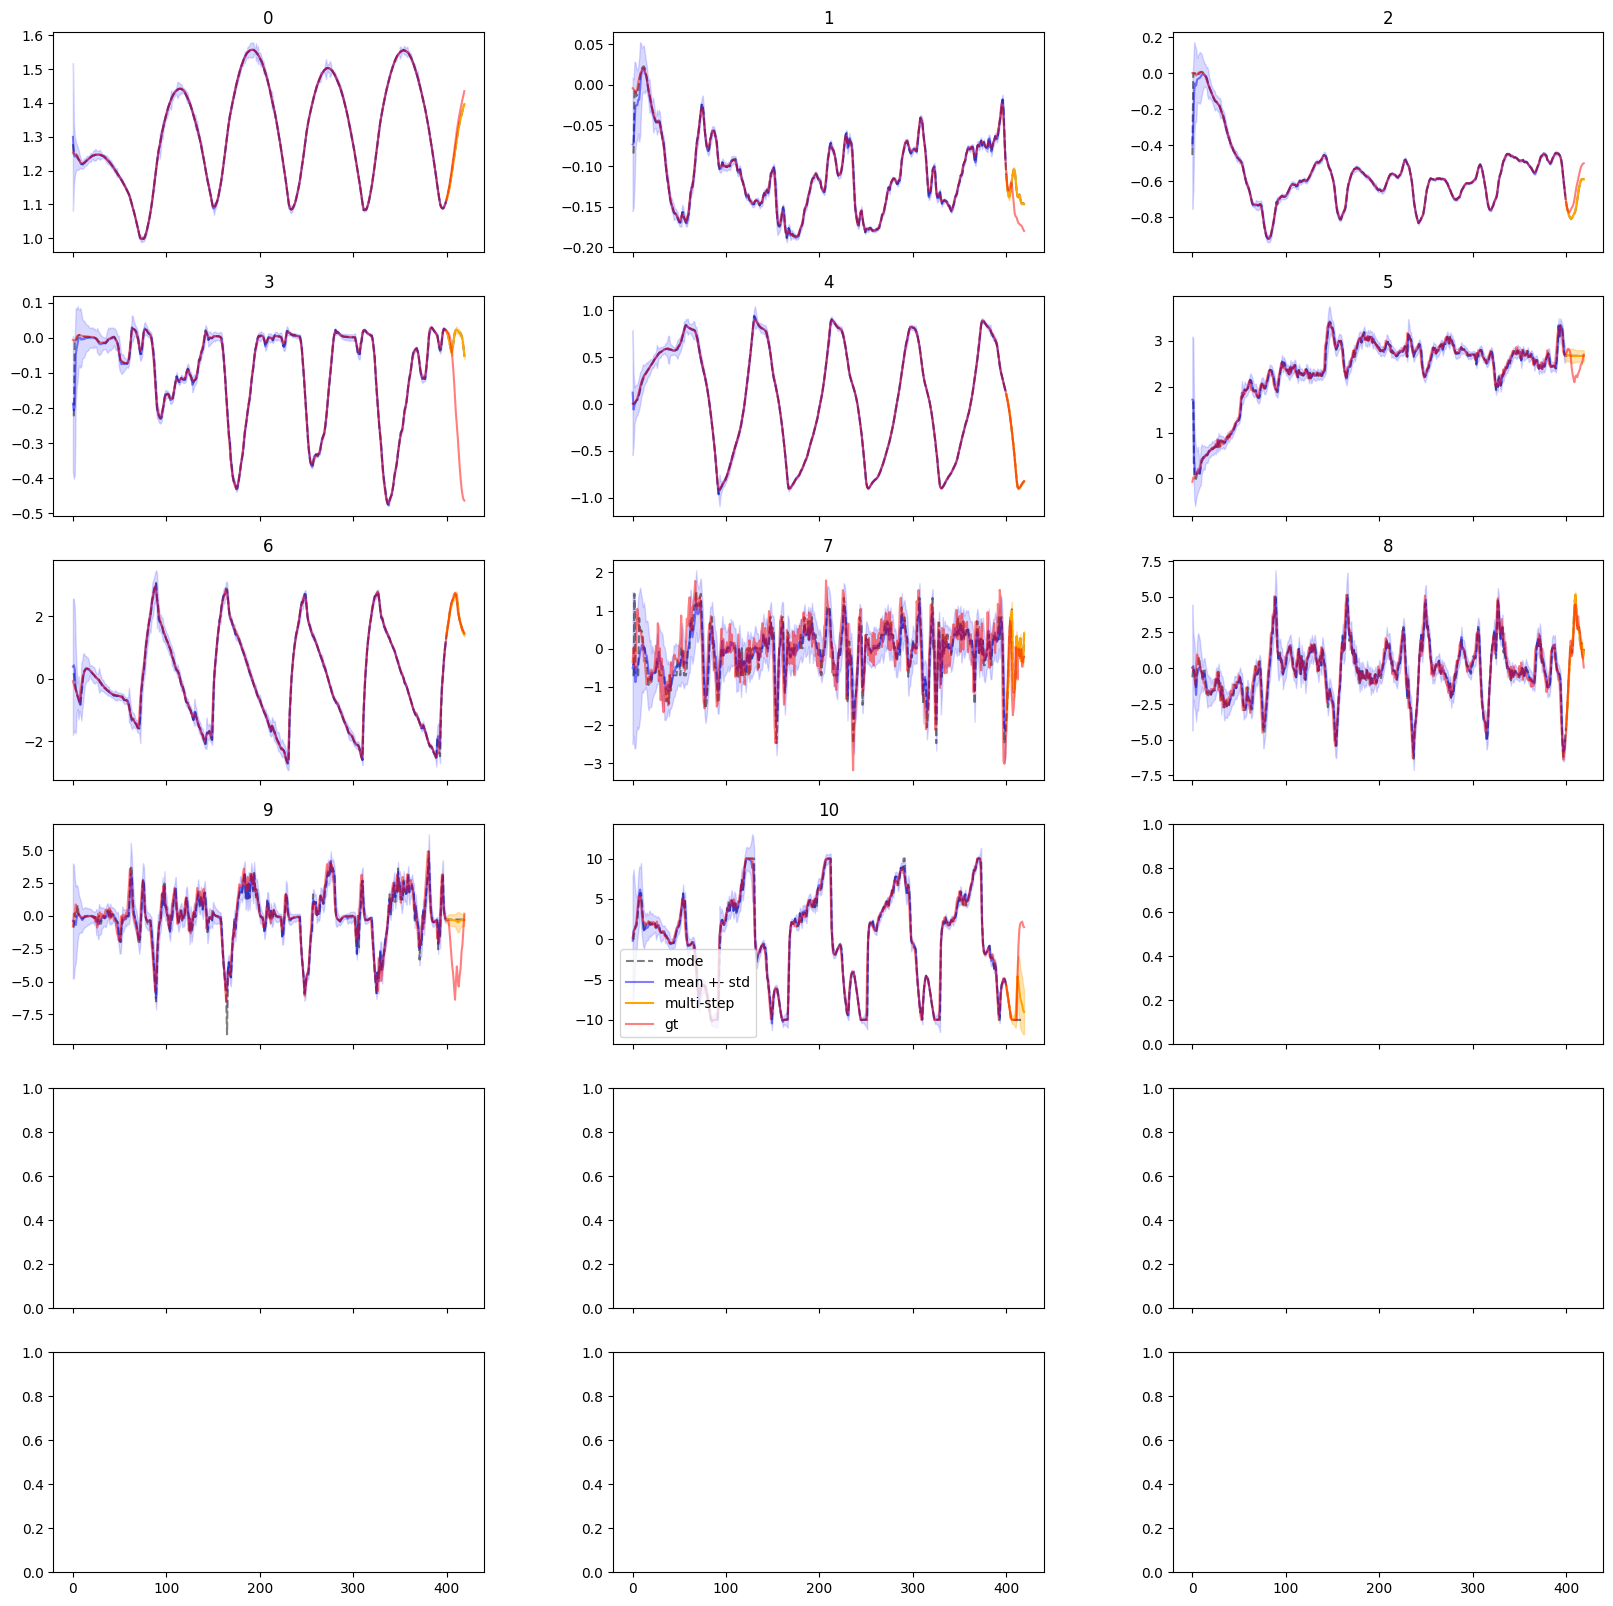

In [27]:
start_from = 0
f, axes = plt.subplots(6, 3, figsize=(20, 20), gridspec_kw={'wspace':0.3}, sharex=True)
axes = list(np.array(axes).flatten())
for dim in range(n_observations):
    groundtruth = X[init_index+1:init_index+context_length+1+prediction_horizon, dim].flatten()
    size_all = len(groundtruth)
    
    ts_max = icl_object[dim].rescaling_max
    ts_min = icl_object[dim].rescaling_min
    
    # -------------------- Useful for Plots --------------------
    mode_arr = ((icl_object[dim].mode_arr.flatten() - up_shift) / rescale_factor) * (ts_max - ts_min) + ts_min 
    mean_arr = ((icl_object[dim].mean_arr.flatten() - up_shift) / rescale_factor) * (ts_max - ts_min) + ts_min
    sigma_arr = (icl_object[dim].sigma_arr.flatten() / rescale_factor) * (ts_max - ts_min)

    # -------------------- Trajectory visualization --------------------
    x = np.arange(mean_arr.shape[0])
    axes[dim].plot(x[start_from:], mode_arr[start_from:], 'k--', label='mode', alpha=.5)
    # single step
    axes[dim].plot(x[start_from:-prediction_horizon], mean_arr[start_from:-prediction_horizon], label='mean +- std', color='blue', alpha=.5)
    axes[dim].fill_between(
        x=x[start_from:-prediction_horizon], 
        y1=mean_arr[start_from:-prediction_horizon]-sigma_arr[start_from:-prediction_horizon], 
        y2=mean_arr[start_from:-prediction_horizon]+sigma_arr[start_from:-prediction_horizon],
        alpha=.15,
        color='blue',
    )
    # multi_step
    axes[dim].plot(x[-prediction_horizon:], mean_arr[-prediction_horizon:], label='multi-step', color='orange')
    axes[dim].fill_between(
        x=x[-prediction_horizon:], 
        y1=mean_arr[-prediction_horizon:]-sigma_arr[-prediction_horizon:], 
        y2=mean_arr[-prediction_horizon:]+sigma_arr[-prediction_horizon:],
        alpha=.3,
        color='orange',
    )

    axes[dim].plot(x[start_from:], groundtruth[start_from:], label='gt', color='red', alpha=.5)
    axes[dim].set_title(f"{dim}")
    if dim > 15:
        axes[dim].set_xlabel("timesteps")
    # axes[dim].set_ylabel("feature")
axes[dim].legend()
# f.suptitle(f'Halfcheetah - expert policy', y=-1.1)
# plt.savefig(f"multi_step_halfcheetah_expert.png")
plt.show()

### Compare learned distribution with the groundtruth discretized transition rule

## Multi-step prediction using the MC kernel

In [28]:
rescale_factor = 7.0
up_shift = 1.5

trainer = trainers.RLICLTrainer(
    model=model,
    tokenizer=tokenizer,
    n_observations=n_observations,
    n_actions=n_actions,
    rescale_factor=rescale_factor,
    up_shift=up_shift,
)

trainer.update_context(
    time_series=copy.copy(time_series), 
    mean_series=copy.copy(time_series),
    sigma_series=np.zeros_like(time_series),
    context_length=context_length
)

trainer.icl(verbose=1)

_ = trainer.compute_statistics()

icl / state dim: 100%|███████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.27it/s]


In [29]:
# MC kernel
transition_matrix_NN, transition_matrix_OT = trainer.build_tranistion_matrices(verbose=0)

icl / state dim:   0%|                                                                                            | 0/11 [00:00<?, ?it/s]/home/abenechehab/llmicl/src/llmicl/matrix_completion/utils.py:32: RuntimeWarning: invalid value encountered in divide
  normalized_probabilities = np.where(non_zero_sums_mask, np.true_divide(prob, row_sums), prob)
icl / state dim: 100%|███████████████████████████████████████████████████████████████████████████████████| 11/11 [11:31<00:00, 62.91s/it]


In [30]:
# multi-step prediction
mc_predictions = trainer.predict_long_horizon_MC(
    prediction_horizon=prediction_horizon,
)

## Visualize

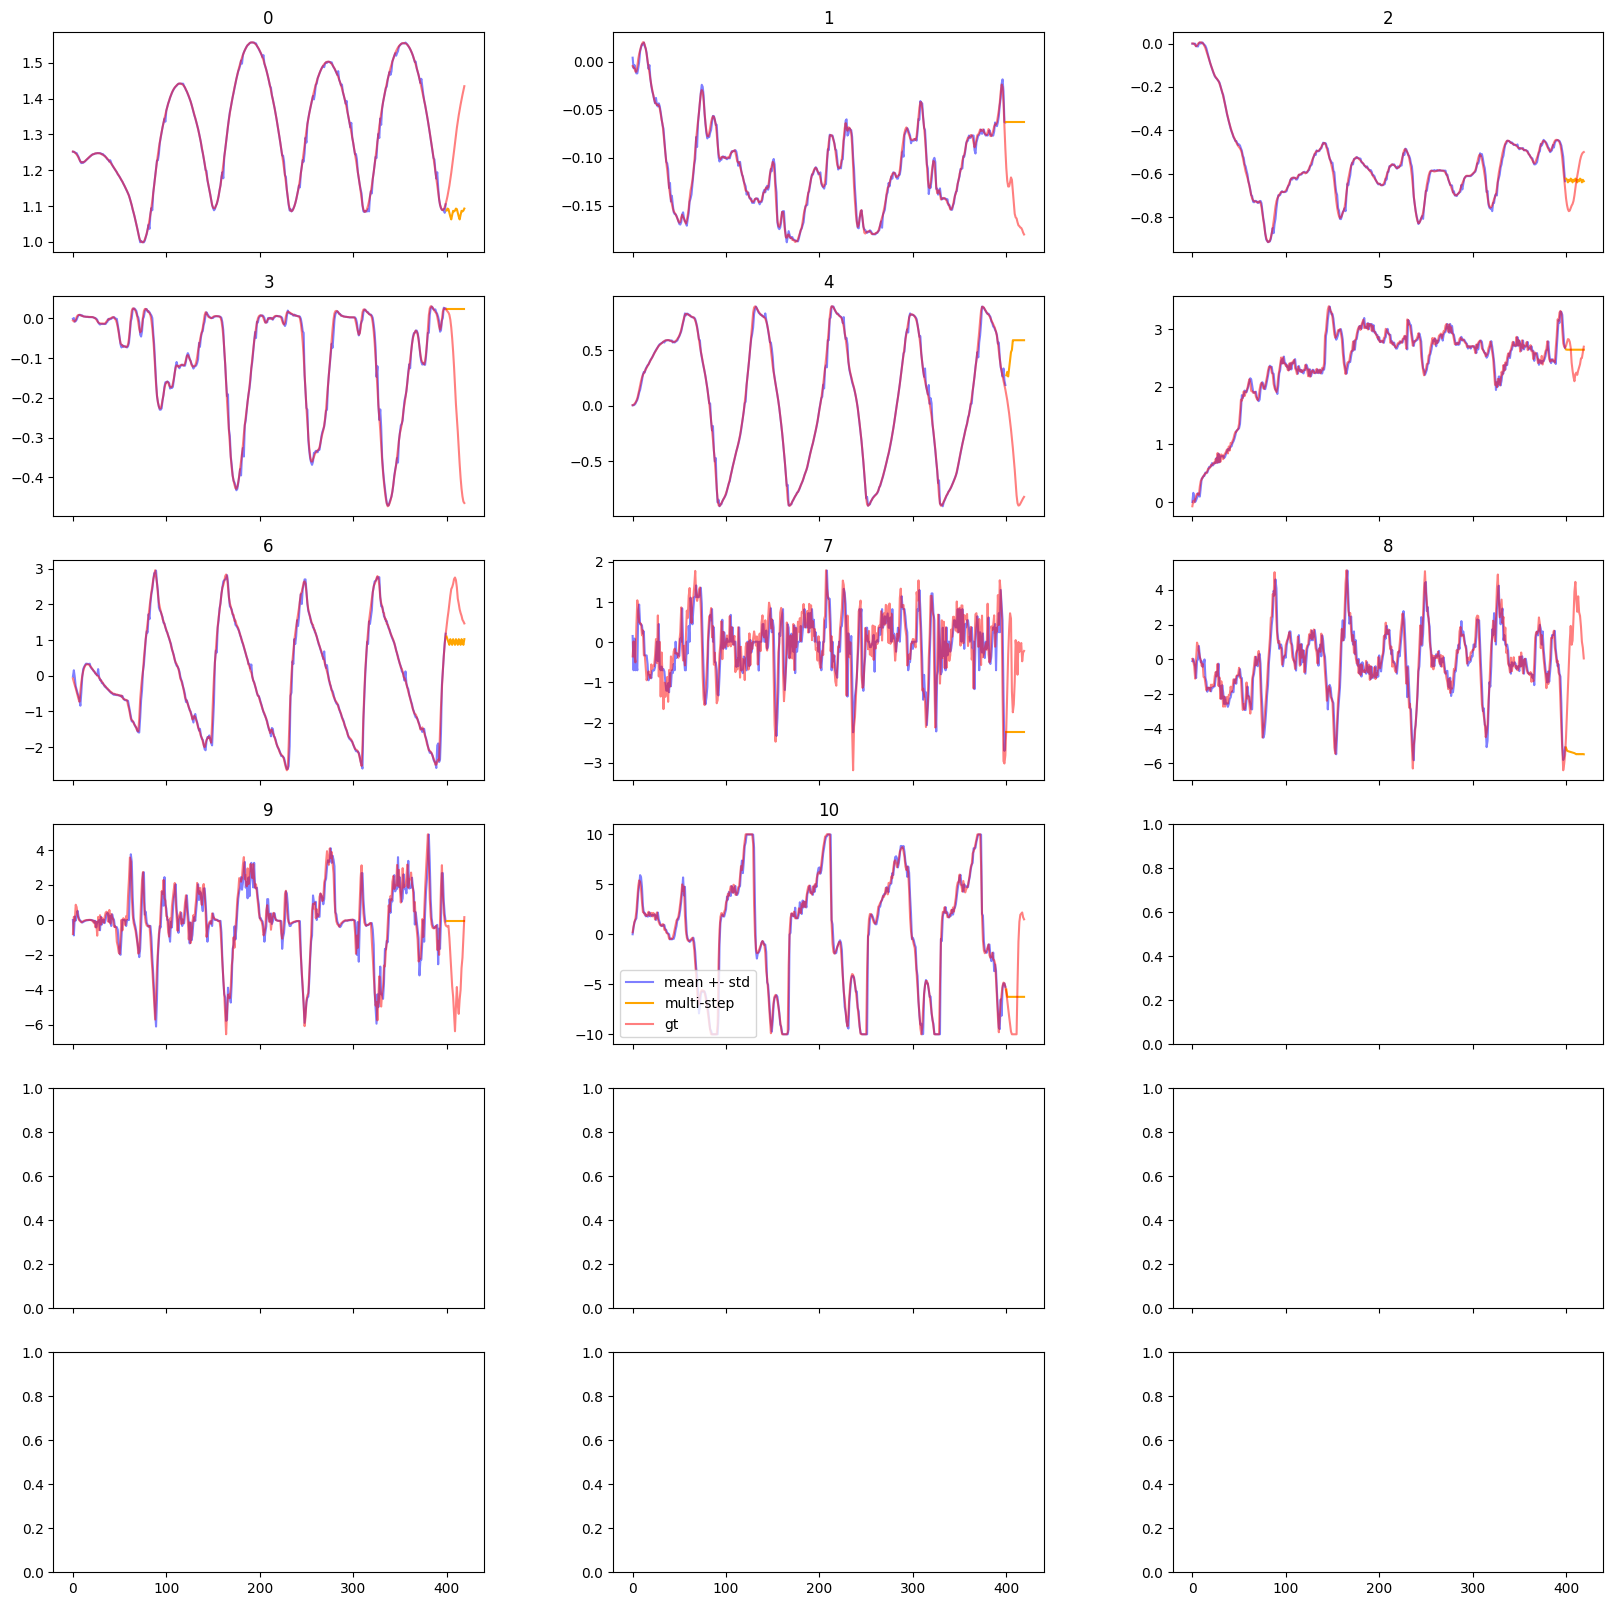

In [31]:
start_from = 0
f, axes = plt.subplots(6, 3, figsize=(20, 20), gridspec_kw={'wspace':0.3}, sharex=True)
axes = list(np.array(axes).flatten())
for dim in range(n_observations):
    groundtruth = X[init_index+1:init_index+context_length+1+prediction_horizon, dim].flatten()
    size_all = len(groundtruth)

    # -------------------- Trajectory visualization --------------------
    x = np.arange(mc_predictions.shape[0])
    # axes[dim].plot(x[start_from:], mode_arr[start_from:], 'k--', label='mode', alpha=.5)
    # single step
    axes[dim].plot(x[start_from:-prediction_horizon], mc_predictions[start_from:-prediction_horizon, dim], label='mean +- std', color='blue', alpha=.5)
    # axes[dim].fill_between(
    #     x=x[start_from:-prediction_horizon], 
    #     y1=mean_arr[start_from:-prediction_horizon]-sigma_arr[start_from:-prediction_horizon], 
    #     y2=mean_arr[start_from:-prediction_horizon]+sigma_arr[start_from:-prediction_horizon],
    #     alpha=.15,
    #     color='blue',
    # )
    # multi_step
    axes[dim].plot(x[-prediction_horizon:], mc_predictions[-prediction_horizon:, dim], label='multi-step', color='orange')
    # axes[dim].fill_between(
    #     x=x[-prediction_horizon:], 
    #     y1=mean_arr[-prediction_horizon:]-sigma_arr[-prediction_horizon:], 
    #     y2=mean_arr[-prediction_horizon:]+sigma_arr[-prediction_horizon:],
    #     alpha=.3,
    #     color='orange',
    # )
    axes[dim].plot(x[start_from:], groundtruth[start_from:], label='gt', color='red', alpha=.5)
    axes[dim].set_title(f"{dim}")
    if dim > 15:
        axes[dim].set_xlabel("timesteps")
    # axes[dim].set_ylabel("feature")
axes[dim].legend()
# f.suptitle(f'Halfcheetah - expert policy', y=-1.1)
# plt.savefig(f"multi_step_halfcheetah_expert.png")
plt.show()

## combine the two

In [230]:
from scipy.interpolate import make_interp_spline

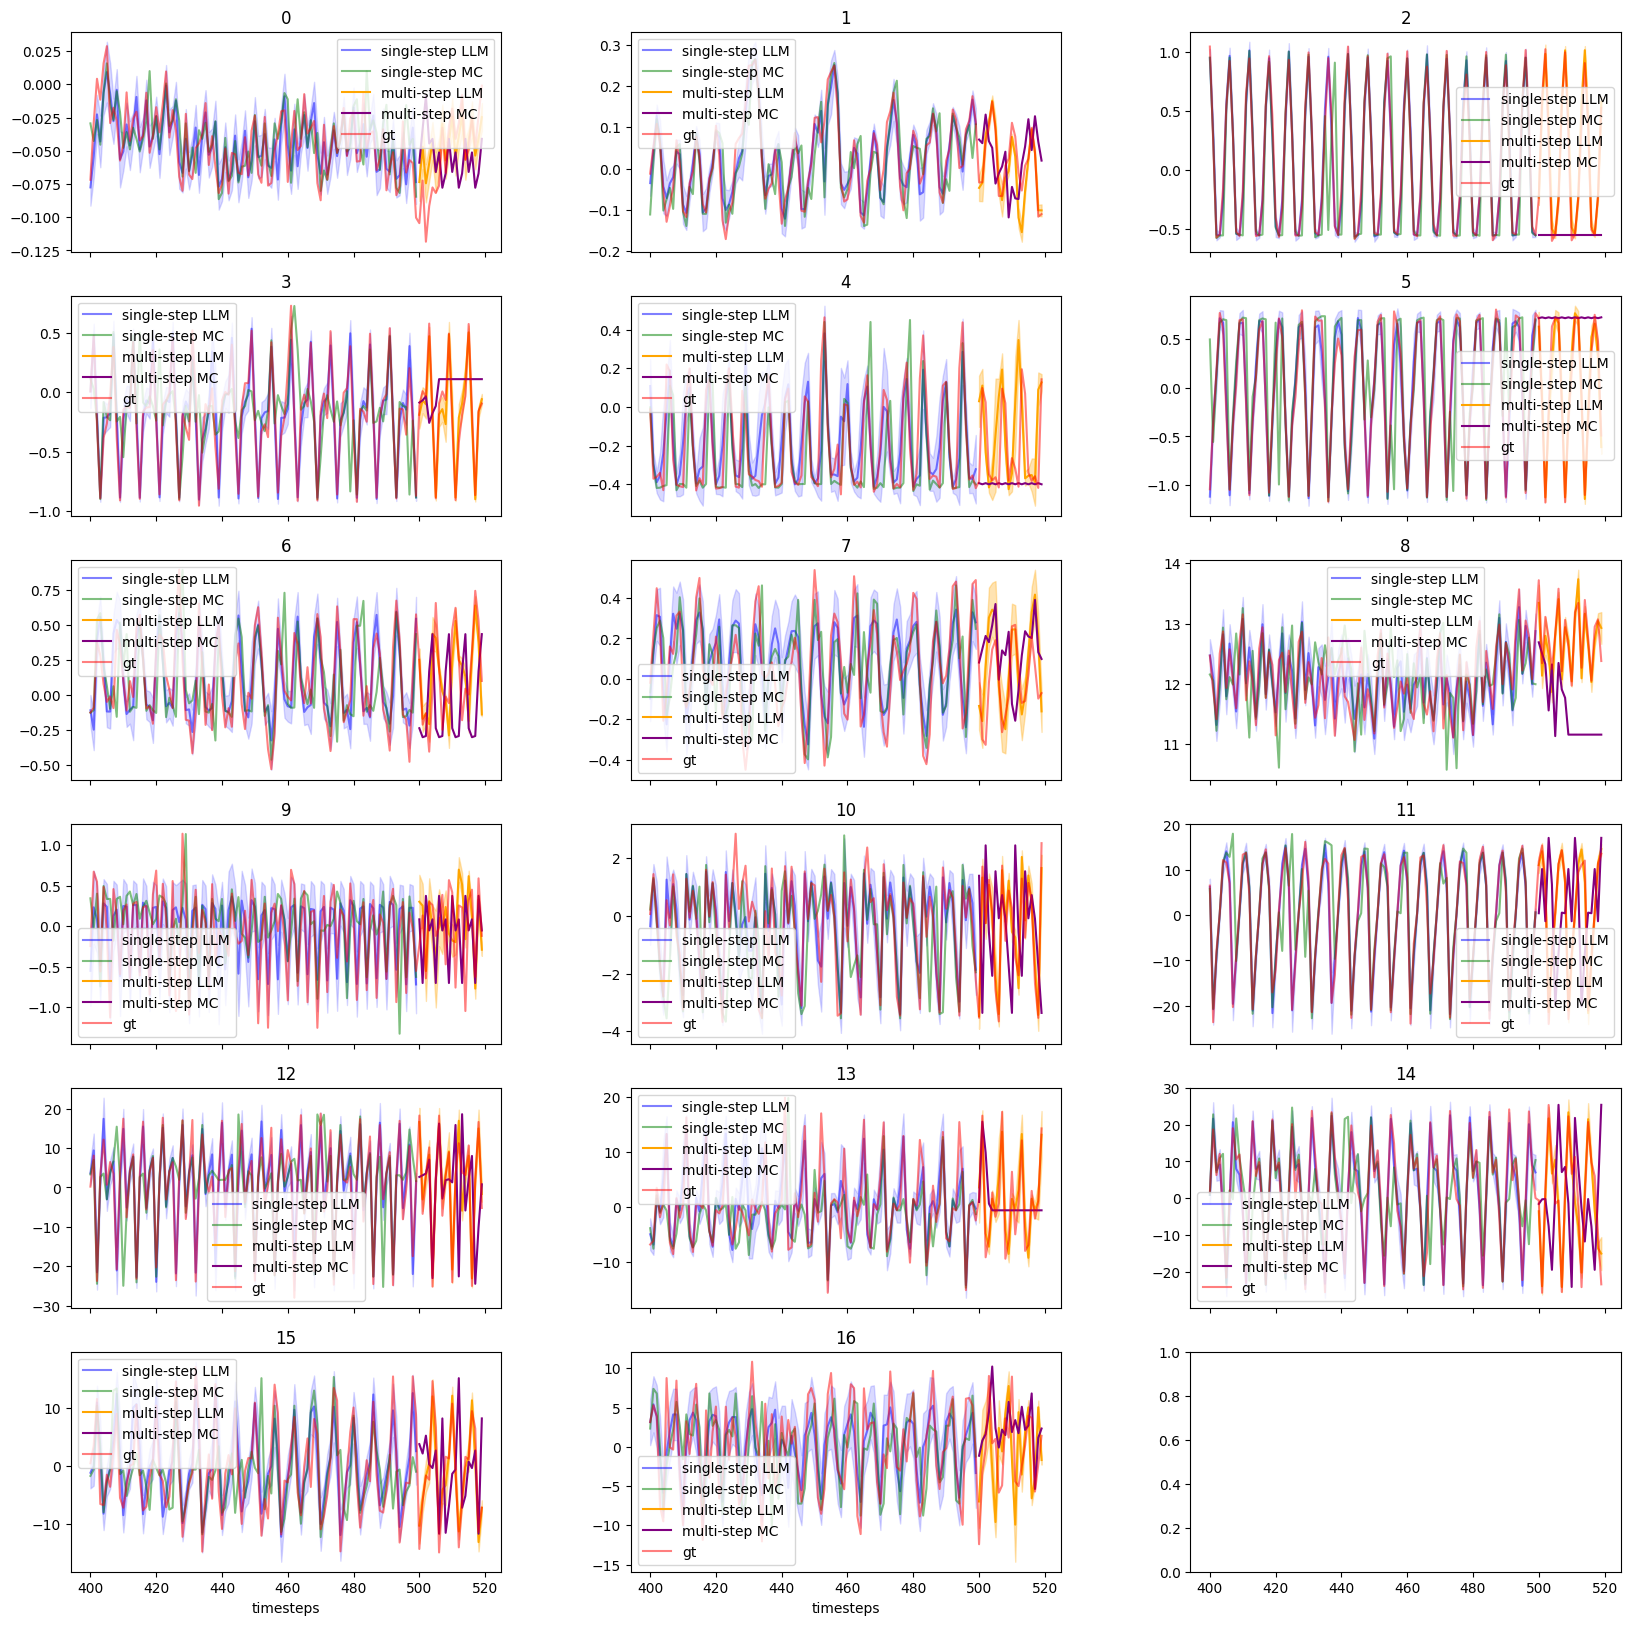

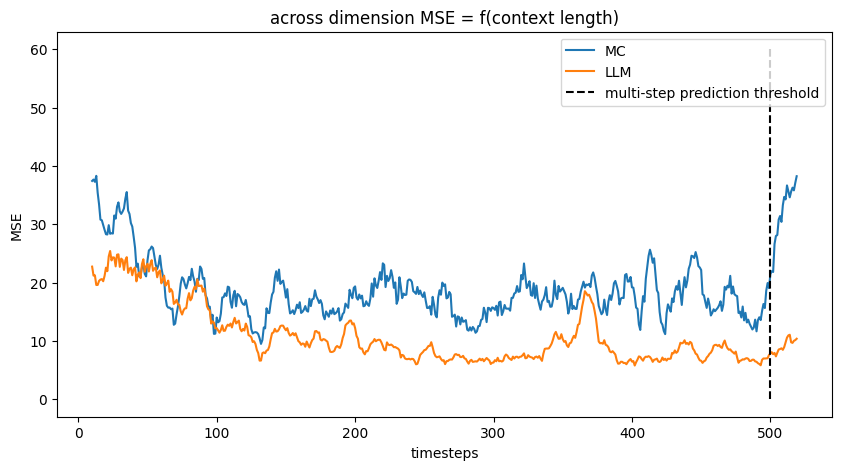

In [244]:
start_from = 400
all_mean_predictions = np.zeros((context_length+prediction_horizon, 17))
f, axes = plt.subplots(6, 3, figsize=(20, 20), gridspec_kw={'wspace':0.3}, sharex=True)
axes = list(np.array(axes).flatten())
for dim in range(n_observations):
    groundtruth = X[init_index+1:init_index+context_length+1+prediction_horizon, dim].flatten()
    size_all = len(groundtruth)
    
    ts_max = icl_object[dim].rescaling_max
    ts_min = icl_object[dim].rescaling_min
    
    # -------------------- Useful for Plots --------------------
    mode_arr = ((icl_object[dim].mode_arr.flatten() - up_shift) / rescale_factor) * (ts_max - ts_min) + ts_min 
    mean_arr = ((icl_object[dim].mean_arr.flatten() - up_shift) / rescale_factor) * (ts_max - ts_min) + ts_min
    sigma_arr = (icl_object[dim].sigma_arr.flatten() / rescale_factor) * (ts_max - ts_min)

    all_mean_predictions[:, dim] = mean_arr

    # -------------------- Trajectory visualization --------------------
    x = np.arange(mean_arr.shape[0])
    # axes[dim].plot(x[start_from:], mode_arr[start_from:], 'k--', label='mode', alpha=.5)
    # single step
    axes[dim].plot(x[start_from:-prediction_horizon], mean_arr[start_from:-prediction_horizon], label='single-step LLM', color='blue', alpha=.5)
    axes[dim].fill_between(
        x=x[start_from:-prediction_horizon], 
        y1=mean_arr[start_from:-prediction_horizon]-sigma_arr[start_from:-prediction_horizon], 
        y2=mean_arr[start_from:-prediction_horizon]+sigma_arr[start_from:-prediction_horizon],
        alpha=.15,
        color='blue',
    )
    axes[dim].plot(x[start_from:-prediction_horizon], mc_predictions[start_from:-prediction_horizon, dim], label='single-step MC', color='green', alpha=.5)
    # multi_step
    axes[dim].plot(x[-prediction_horizon:], mean_arr[-prediction_horizon:], label='multi-step LLM', color='orange')
    axes[dim].fill_between(
        x=x[-prediction_horizon:], 
        y1=mean_arr[-prediction_horizon:]-sigma_arr[-prediction_horizon:], 
        y2=mean_arr[-prediction_horizon:]+sigma_arr[-prediction_horizon:],
        alpha=.3,
        color='orange',
    )
    axes[dim].plot(x[-prediction_horizon:], mc_predictions[-prediction_horizon:, dim], label='multi-step MC', color='purple')

    axes[dim].plot(x[start_from:], groundtruth[start_from:], label='gt', color='red', alpha=.5)
    axes[dim].set_title(f"{dim}")
    if dim > 14:
        axes[dim].set_xlabel("timesteps")
    # axes[dim].set_ylabel("feature")
    axes[dim].legend()

# f.suptitle(f'Halfcheetah - expert policy', y=-1.1)
# plt.savefig(f"multi_step_halfcheetah_expert.png")

f, axes = plt.subplots(1, 1, figsize=(10, 5))
axes = list(np.array(axes).flatten())

# MSE
window_size = 10
mc_l2_error = np.linalg.norm(X[init_index+1:init_index+context_length+1+prediction_horizon,:n_observations] - mc_predictions, axis=1)
axes[-1].plot(
    x[window_size:], 
    pd.Series(mc_l2_error).rolling(window_size).mean().to_numpy()[window_size:],
    label='MC'
)
llm_l2_error = np.linalg.norm(X[init_index+1:init_index+context_length+1+prediction_horizon,:n_observations] - all_mean_predictions, axis=1)
axes[-1].plot(
    x[window_size:], 
    pd.Series(llm_l2_error).rolling(window_size).mean().to_numpy()[window_size:],
    label='LLM'
)
axes[-1].vlines(
    x=context_length, ymin=0, ymax=60, color='black', linestyle='--', label='multi-step prediction threshold'
)
axes[-1].set_xlabel("timesteps")
axes[-1].set_ylabel("MSE")
axes[-1].legend()
axes[-1].set_title("across dimension MSE = f(context length)")

plt.show()

## Average over multiple trajectories

In [ ]:
n_experiments = 19
prediction_horizon = 20
context_length = 500

llm_errors = np.zeros((context_length+prediction_horizon, n_experiments))
mc_errors = np.zeros((context_length+prediction_horizon, n_experiments))
for i_exp in tqdm(range(n_experiments), desc='nbr of experiments'):
    init_index = int(i_exp * 1000)
    time_series = X[init_index:init_index+context_length, :n_observations]
    
    # ----------------- multi-step prediction -----------------
    trainer = trainers.RLICLTrainer(
        env=env,
        model=model,
        tokenizer=tokenizer,
        rescale_factor=rescale_factor,
        up_shift=up_shift,
    )
    trainer.update_context(
        time_series=copy.copy(time_series), 
        mean_series=copy.copy(time_series),
        sigma_series=np.zeros_like(time_series),
        context_length=context_length,
        update_min_max=True,
    )
    trainer.icl(verbose=0)

    # -------- Markov chain --------
    trainer.compute_statistics()
    trainer.build_tranistion_matrices(verbose=0)
    mc_predictions = trainer.predict_long_horizon_MC(
        prediction_horizon=prediction_horizon,
    )
    mc_errors[:, i_exp] = np.linalg.norm(X[init_index+1:init_index+context_length+1+prediction_horizon,:n_observations] - mc_predictions, axis=1)
    
    # -------- LLM --------
    icl_object = trainer.predict_long_horizon_llm(prediction_horizon=prediction_horizon)
    
    llm_predictions = np.zeros((context_length+prediction_horizon, n_observations))
    for dim in range(n_observations):
        groundtruth = X[init_index+1:init_index+context_length+1+prediction_horizon, dim].flatten()
        size_all = len(groundtruth)
        
        ts_max = icl_object[dim].rescaling_max
        ts_min = icl_object[dim].rescaling_min
        
        mode_arr = ((icl_object[dim].mode_arr.flatten() - up_shift) / rescale_factor) * (ts_max - ts_min) + ts_min 
        all_mean_predictions[:, dim] = mode_arr
    
    llm_errors[:, i_exp] = np.linalg.norm(X[init_index+1:init_index+context_length+1+prediction_horizon,:n_observations] - all_mean_predictions, axis=1)

# save predictions
np.save(f'llm_errors_{dataset}.npy', llm_errors)
np.save(f'mc_errors_{dataset}.npy', mc_errors)

nbr of experiments:   0%|                                                                                         | 0/19 [00:00<?, ?it/s]/home/abenechehab/llmicl/src/llmicl/interfaces/trainers.py:427: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2))))
/home/abenechehab/llmicl/src/llmicl/legacy/models/ICL.py:563: RuntimeWarning: divide by zero encountered in log
  log_ratio = np.log(self.bin_height_arr) - np.log(Multi_PDF.bin_height_arr)
/home/abenechehab/llmicl/src/llmicl/legacy/models/ICL.py:564: RuntimeWarning: invalid value encountered in multiply
  weighted_log_ratio = log_ratio * self.bin_height_arr * self.bin_width_arr

icl / state dim:   0%|                                                                                            | 0/17 [00:00<?, ?it/s]

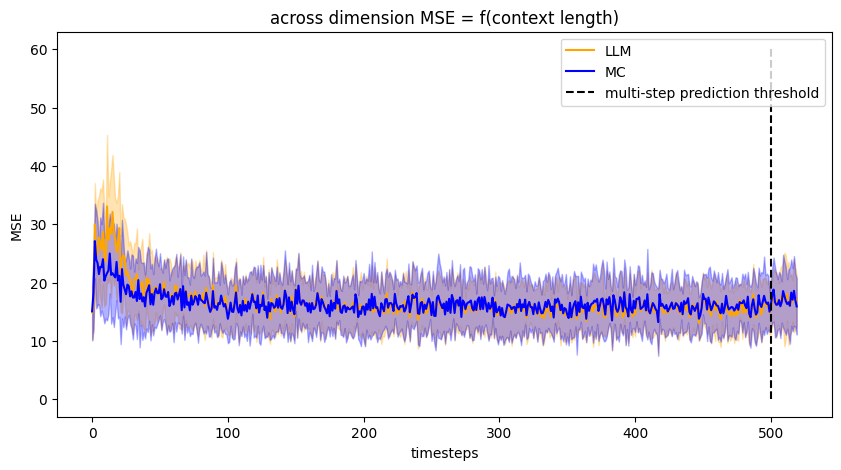

In [264]:
# save predictions
# llm_errors = np.load('llm_errors.npy')
# mc_errors = np.load('mc_errors.npy')

f, axes = plt.subplots(1, 1, figsize=(10, 5))
axes = list(np.array(axes).flatten())

# MSE
window_size = 10
x = np.arange(context_length+prediction_horizon)
# LLM
axes[-1].plot(x, llm_errors.mean(axis=1), label='LLM', color='orange')
axes[-1].fill_between(
    x=x, 
    y1=llm_errors.mean(axis=1)-llm_errors.std(axis=1), 
    y2=llm_errors.mean(axis=1)+llm_errors.std(axis=1),
    alpha=.3,
    color='orange',
)
# MC
axes[-1].plot(x, mc_errors.mean(axis=1), label='MC', color='blue')
axes[-1].fill_between(
    x=x, 
    y1=mc_errors.mean(axis=1)-mc_errors.std(axis=1), 
    y2=mc_errors.mean(axis=1)+mc_errors.std(axis=1),
    alpha=.3,
    color='blue',
)

axes[-1].vlines(
    x=context_length, ymin=0, ymax=60, color='black', linestyle='--', label='multi-step prediction threshold'
)
axes[-1].set_xlabel("timesteps")
axes[-1].set_ylabel("MSE")
axes[-1].legend()
axes[-1].set_title("across dimension MSE = f(context length)")

plt.show()

## multiple datasets, same plot, baselines

nbr of experiments: 100%|███████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 212.69it/s]


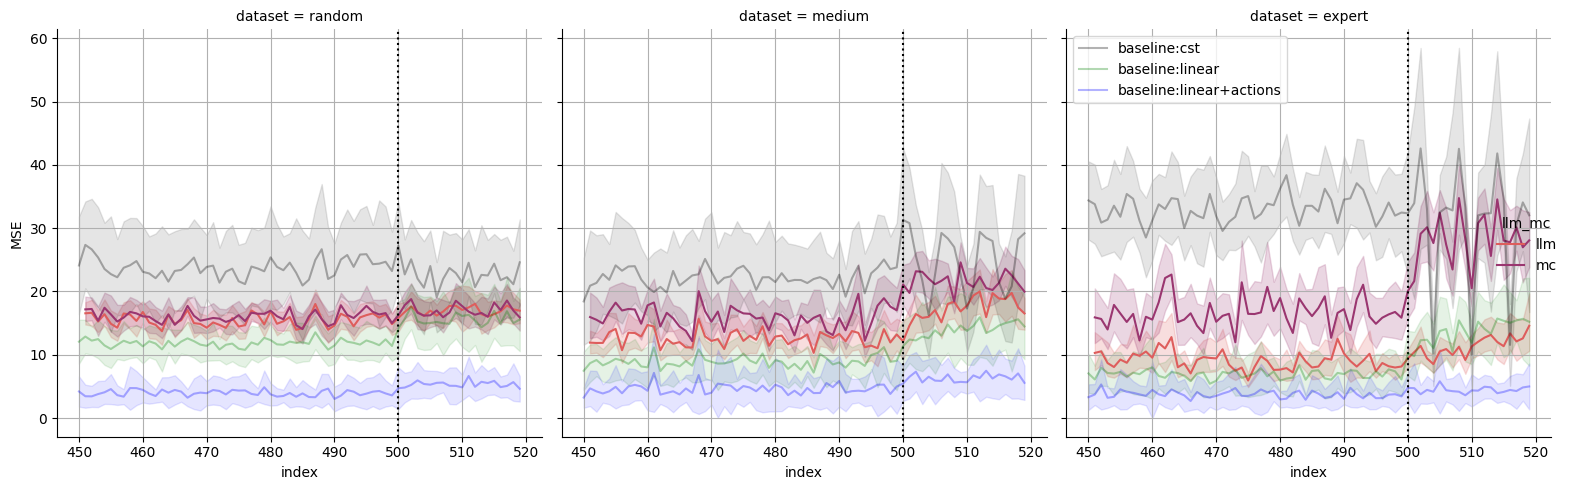

In [351]:
plot_from = 450

columns = ['prediction', 'llm_mc', 'dataset', 'episode']
df = pd.DataFrame(columns=columns)
for dataset_name in ['random', 'medium', 'expert']:
    # load predictions
    llm_errors = np.load(f'llm_errors_{dataset_name}.npy')
    mc_errors = np.load(f'mc_errors_{dataset_name}.npy')

    for i in range(llm_errors.shape[1]):
        # llm
        mini_df = pd.DataFrame(columns=columns)
        mini_df['prediction'] = llm_errors[:, i]
        mini_df['llm_mc'] = 'llm'
        mini_df['dataset'] = dataset_name
        mini_df['episode'] = i
        df = pd.concat([df, mini_df], axis=0) 
        # mc
        mini_df = pd.DataFrame(columns=columns)
        mini_df['prediction'] = mc_errors[:, i]
        mini_df['llm_mc'] = 'mc'
        mini_df['dataset'] = dataset_name
        mini_df['episode'] = i
        df = pd.concat([df, mini_df], axis=0) 
    
# f, axes = plt.subplots(1, 1, figsize=(10, 5))
# axes = list(np.array(axes).flatten())
df = df.reset_index()
g = sns.relplot(
    data=df.loc[df['index'] > plot_from], x='index', y="prediction", col="dataset", hue="llm_mc", palette="flare", kind="line",
)
# ax.vlines(
#     x=context_length, ymin=0, ymax=50, color='black', linestyle='--', label='multi-step prediction threshold'
# )
dataset_list = ['random', 'medium', 'expert']
for ax_idx, ax in enumerate(g.axes.flat):
    ax.axvline(x=context_length, color='black', linestyle=':')
    ax.grid(True)
    ax.set_ylabel('MSE')

    # train linear regression baseline
    X_baselines, _, n_observations, n_actions = load_offline_dataset(path=f"/home/abenechehab/d4rl_halfcheetah/d4rl_{dataset_list[ax_idx]}/X_train.csv")

    X_train_actions = copy.copy(np.concatenate([X_baselines[:,:n_observations], X_baselines[:,n_observations+1:n_observations+1+n_actions]], axis=1)[:-1])
    X_train = copy.copy(X_baselines[:-1,:n_observations])
    y_train = copy.copy(X_baselines[1:,:n_observations])
    
    nan_indices = np.unique(np.argwhere(np.isnan(X_train_actions))[:,0])
    mask = np.ones(X_train_actions.shape[0], bool)
    mask[nan_indices] = False
    
    X_train = X_train[mask]
    X_train_actions = X_train_actions[mask]
    y_train = y_train[mask]

    # model
    linreg_model = LinearRegression(fit_intercept=True)
    linreg_model.fit(X_train, y_train)
    # model action
    linreg_model_actions = LinearRegression(fit_intercept=True)
    linreg_model_actions.fit(X_train_actions, y_train)
    
    # constant and linreg baselines
    X_cst, _, _, _ = load_offline_dataset(path=f"/home/abenechehab/d4rl_halfcheetah/d4rl_{dataset_list[ax_idx]}/X_test.csv")
    cst_errors = np.zeros((context_length+prediction_horizon, n_experiments))
    linreg_errors = np.zeros((context_length+prediction_horizon, n_experiments))
    linreg_actions_errors = np.zeros((context_length+prediction_horizon, n_experiments))
    for i_exp in tqdm(range(n_experiments), desc='nbr of experiments'):
        init_index = int(i_exp * 1000)
        # constant
        cst_pred = copy.copy(X_cst[init_index:init_index+context_length+prediction_horizon,:n_observations])
        cst_pred[context_length:context_length+prediction_horizon] = cst_pred[context_length-1] 
        cst_errors[:, i_exp] = np.linalg.norm(X_cst[init_index+1:init_index+context_length+1+prediction_horizon,:n_observations] - cst_pred, axis=1)
        # linear
        linreg_input_actions = np.concatenate([
            X_cst[init_index:init_index+context_length+prediction_horizon,:n_observations], 
            X_cst[init_index:init_index+context_length+prediction_horizon,n_observations+1:n_observations+1+n_actions]
        ], axis=1)
        linreg_input = X_cst[init_index:init_index+context_length+prediction_horizon,:n_observations]
        linreg_pred = linreg_model.predict(linreg_input)
        linreg_pred_actions = linreg_model_actions.predict(linreg_input_actions)
        for h in range(prediction_horizon):
            new_input_actions = np.concatenate(
                [
                    linreg_pred_actions[context_length+h-1].reshape((1, -1)), 
                    X_cst[init_index+context_length+h,n_observations+1:n_observations+1+n_actions].reshape((1, -1))
                ], 
                axis=1
            )
            new_pred = linreg_model.predict(linreg_pred[context_length+h-1].reshape((1, -1)))
            new_pred_actions = linreg_model_actions.predict(new_input_actions)
            linreg_pred[context_length+h] = copy.copy(new_pred)
            linreg_pred_actions[context_length+h] = copy.copy(new_pred_actions)
        linreg_errors[:, i_exp] = np.linalg.norm(X_cst[init_index+1:init_index+context_length+1+prediction_horizon,:n_observations] - linreg_pred, axis=1)
        linreg_actions_errors[:, i_exp] = np.linalg.norm(X_cst[init_index+1:init_index+context_length+1+prediction_horizon,:n_observations] - linreg_pred_actions, axis=1)
    # CST
    ax.plot(np.arange(context_length+prediction_horizon)[plot_from:], cst_errors.mean(axis=1)[plot_from:], label='baseline:cst', color='black', alpha=.3)
    ax.fill_between(
        x=np.arange(context_length+prediction_horizon)[plot_from:], 
        y1=cst_errors.mean(axis=1)[plot_from:]-cst_errors.std(axis=1)[plot_from:], 
        y2=cst_errors.mean(axis=1)[plot_from:]+cst_errors.std(axis=1)[plot_from:],
        alpha=.1,
        color='black',
    )
    # LinReg
    ax.plot(np.arange(context_length+prediction_horizon)[plot_from:], linreg_errors.mean(axis=1)[plot_from:], label='baseline:linear', color='green', alpha=.3)
    ax.fill_between(
        x=np.arange(context_length+prediction_horizon)[plot_from:], 
        y1=linreg_errors.mean(axis=1)[plot_from:]-linreg_errors.std(axis=1)[plot_from:], 
        y2=linreg_errors.mean(axis=1)[plot_from:]+linreg_errors.std(axis=1)[plot_from:],
        alpha=.1,
        color='green',
    )
    # LinReg actions
    ax.plot(np.arange(context_length+prediction_horizon)[plot_from:], linreg_actions_errors.mean(axis=1)[plot_from:], label='baseline:linear+actions', color='blue', alpha=.3)
    ax.fill_between(
        x=np.arange(context_length+prediction_horizon)[plot_from:], 
        y1=linreg_actions_errors.mean(axis=1)[plot_from:]-linreg_actions_errors.std(axis=1)[plot_from:], 
        y2=linreg_actions_errors.mean(axis=1)[plot_from:]+linreg_actions_errors.std(axis=1)[plot_from:],
        alpha=.1,
        color='blue',
    )
    # if ax_idx==2:
    #     sns.move_legend(ax, "up right")
plt.legend()
plt.tight_layout()
plt.show()

## comparison with MLP

In [391]:
from llmicl.rl_helpers import nn_utils

import importlib
importlib.reload(nn_utils)

<module 'llmicl.rl_helpers.nn_utils' from '/home/abenechehab/llmicl/src/llmicl/rl_helpers/nn_utils.py'>

nbr of experiments: 100%|████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 16.42it/s]


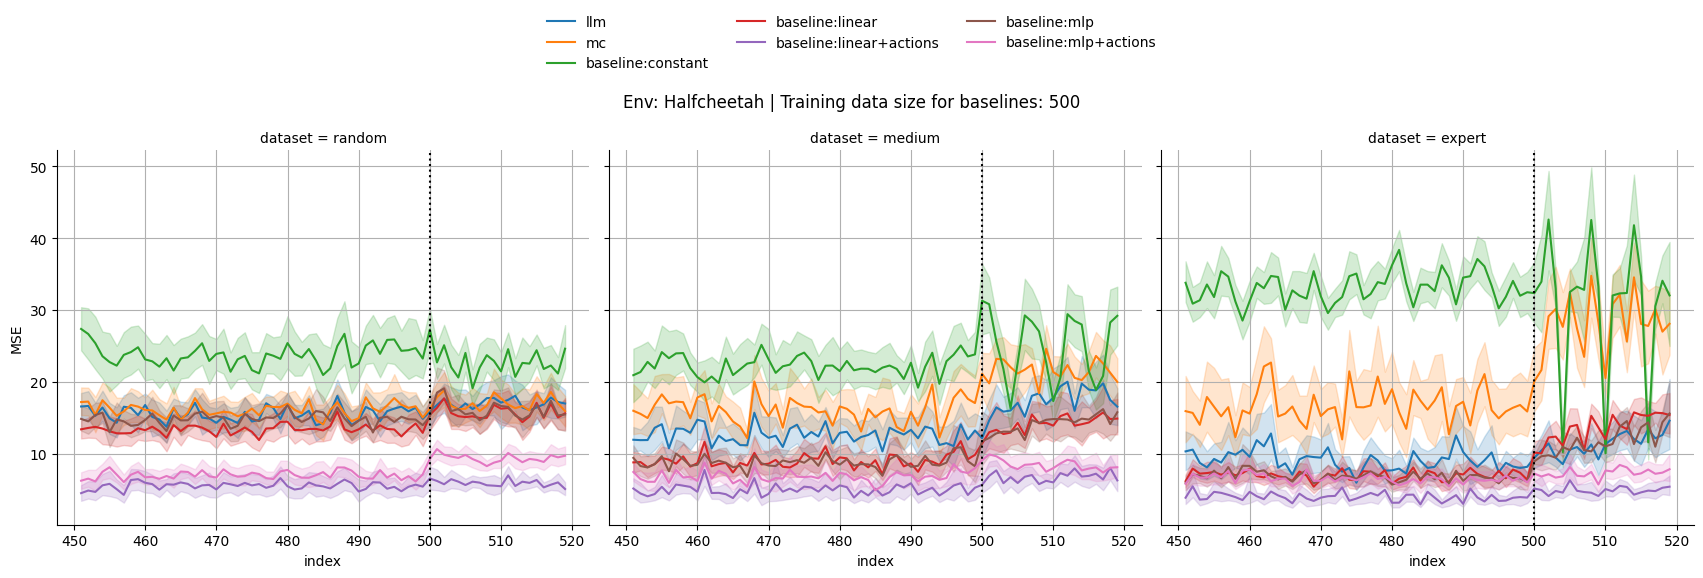

In [400]:
plot_from = 450
training_data_size = 500

columns = ['prediction', 'model', 'dataset', 'episode']
df = pd.DataFrame(columns=columns)
for dataset_name in ['random', 'medium', 'expert']:
    # load predictions
    llm_errors = np.load(f'artifacts/data/llm_errors_{dataset_name}.npy')
    mc_errors = np.load(f'artifacts/data/mc_errors_{dataset_name}.npy')
    
    # train linear regression baseline and MLP
    X_baselines, _, n_observations, n_actions = load_offline_dataset(path=f"/home/abenechehab/datasets/HalfCheetah/d4rl_{dataset_name}/X_train.csv")
    
    X_train_actions = copy.copy(np.concatenate([X_baselines[:,:n_observations], X_baselines[:,n_observations+1:n_observations+1+n_actions]], axis=1)[:-1])
    X_train = copy.copy(X_baselines[:-1,:n_observations])
    y_train = copy.copy(X_baselines[1:,:n_observations])
    
    nan_indices = np.unique(np.argwhere(np.isnan(X_train_actions))[:,0])
    mask = np.ones(X_train_actions.shape[0], bool)
    mask[nan_indices] = False
    
    X_train = X_train[mask][:training_data_size]
    X_train_actions = X_train_actions[mask][:training_data_size]
    y_train = y_train[mask][:training_data_size]
    
    # linreg model
    linreg_model = LinearRegression(fit_intercept=True)
    linreg_model.fit(X_train, y_train)
    # linreg model action
    linreg_model_actions = LinearRegression(fit_intercept=True)
    linreg_model_actions.fit(X_train_actions, y_train)
    # mlp
    mlp = nn_utils.NeuralNet(input_size=n_observations, output_size=n_observations)
    _, _, mlp = nn_utils.train_mlp(model=mlp, X_train=X_train, y_train=y_train)
    mlp.eval()
    # mlp + actions
    mlp_actions = nn_utils.NeuralNet(input_size=n_observations+n_actions, output_size=n_observations)
    _, _, mlp_actions = nn_utils.train_mlp(model=mlp_actions, X_train=X_train_actions, y_train=y_train)
    mlp_actions.eval()
    
    # constant and linreg baselines
    X_cst, _, _, _ = load_offline_dataset(path=f"/home/abenechehab/datasets/HalfCheetah/d4rl_{dataset_name}/X_test.csv")
    cst_errors = np.zeros((context_length+prediction_horizon, n_experiments))
    linreg_errors = np.zeros((context_length+prediction_horizon, n_experiments))
    linreg_actions_errors = np.zeros((context_length+prediction_horizon, n_experiments))
    mlp_errors = np.zeros((context_length+prediction_horizon, n_experiments))
    mlp_actions_errors = np.zeros((context_length+prediction_horizon, n_experiments))
    for i_exp in tqdm(range(n_experiments), desc='nbr of experiments'):
        init_index = int(i_exp * 1000)
        # constant
        cst_pred = copy.copy(X_cst[init_index:init_index+context_length+prediction_horizon,:n_observations])
        cst_pred[context_length:context_length+prediction_horizon] = cst_pred[context_length-1] 
        cst_errors[:, i_exp] = np.linalg.norm(X_cst[init_index+1:init_index+context_length+1+prediction_horizon,:n_observations] - cst_pred, axis=1)
        
        # linear actions
        linreg_input_actions = np.concatenate([
            X_cst[init_index:init_index+context_length+prediction_horizon,:n_observations], 
            X_cst[init_index:init_index+context_length+prediction_horizon,n_observations+1:n_observations+1+n_actions]
        ], axis=1)
        linreg_pred_actions = linreg_model_actions.predict(linreg_input_actions)
        
        # linear
        linreg_input = X_cst[init_index:init_index+context_length+prediction_horizon,:n_observations]
        linreg_pred = linreg_model.predict(linreg_input)
        
        #mlp
        mlp_pred = mlp(torch.from_numpy(linreg_input).type(torch.FloatTensor)).cpu().detach().numpy()
        
        #mlp + actions
        mlp_actions_pred = mlp_actions(torch.from_numpy(linreg_input_actions).type(torch.FloatTensor)).cpu().detach().numpy()
        
        # multi-step prediction
        for h in range(prediction_horizon):
            # linear + actions
            new_input_actions = np.concatenate(
                [
                    linreg_pred_actions[context_length+h-1].reshape((1, -1)), 
                    X_cst[init_index+context_length+h,n_observations+1:n_observations+1+n_actions].reshape((1, -1))
                ], 
                axis=1
            )
            new_pred_actions = linreg_model_actions.predict(new_input_actions)
            linreg_pred_actions[context_length+h] = copy.copy(new_pred_actions)
            # linear
            new_pred = linreg_model.predict(linreg_pred[context_length+h-1].reshape((1, -1)))
            linreg_pred[context_length+h] = copy.copy(new_pred)
            # mlp
            new_pred = mlp(torch.from_numpy(linreg_pred[context_length+h-1].reshape((1, -1))).type(torch.FloatTensor)).cpu().detach().numpy()
            mlp_pred[context_length+h] = copy.copy(new_pred)
            # mlp actions
            new_input_actions = np.concatenate(
                [
                    mlp_actions_pred[context_length+h-1].reshape((1, -1)), 
                    X_cst[init_index+context_length+h,n_observations+1:n_observations+1+n_actions].reshape((1, -1))
                ], 
                axis=1
            )
            new_pred_actions = mlp_actions(torch.from_numpy(new_input_actions).type(torch.FloatTensor)).cpu().detach().numpy()
            mlp_actions_pred[context_length+h] = copy.copy(new_pred_actions)
            
        linreg_errors[:, i_exp] = np.linalg.norm(
            X_cst[init_index+1:init_index+context_length+1+prediction_horizon,:n_observations] - linreg_pred, 
            axis=1,
        )
        linreg_actions_errors[:, i_exp] = np.linalg.norm(
            X_cst[init_index+1:init_index+context_length+1+prediction_horizon,:n_observations] - linreg_pred_actions, 
            axis=1,
        )
        mlp_errors[:, i_exp] = np.linalg.norm(
            X_cst[init_index+1:init_index+context_length+1+prediction_horizon,:n_observations] - mlp_pred, 
            axis=1,
        )
        mlp_actions_errors[:, i_exp] = np.linalg.norm(
            X_cst[init_index+1:init_index+context_length+1+prediction_horizon,:n_observations] - mlp_actions_pred, 
            axis=1,
        )
    
    for i in range(llm_errors.shape[1]):
        # llm
        mini_df = pd.DataFrame(columns=columns)
        mini_df['prediction'] = llm_errors[:, i]
        mini_df['model'] = 'llm'
        mini_df['dataset'] = dataset_name
        mini_df['episode'] = i
        df = pd.concat([df, mini_df], axis=0) 
        # mc
        mini_df = pd.DataFrame(columns=columns)
        mini_df['prediction'] = mc_errors[:, i]
        mini_df['model'] = 'mc'
        mini_df['dataset'] = dataset_name
        mini_df['episode'] = i
        df = pd.concat([df, mini_df], axis=0) 
        # baseline:constant
        mini_df = pd.DataFrame(columns=columns)
        mini_df['prediction'] = cst_errors[:, i]
        mini_df['model'] = 'baseline:constant'
        mini_df['dataset'] = dataset_name
        mini_df['episode'] = i
        df = pd.concat([df, mini_df], axis=0) 
        # baseline:linear
        mini_df = pd.DataFrame(columns=columns)
        mini_df['prediction'] = linreg_errors[:, i]
        mini_df['model'] = 'baseline:linear'
        mini_df['dataset'] = dataset_name
        mini_df['episode'] = i
        df = pd.concat([df, mini_df], axis=0) 
        # baseline:linear+actions
        mini_df = pd.DataFrame(columns=columns)
        mini_df['prediction'] = linreg_actions_errors[:, i]
        mini_df['model'] = 'baseline:linear+actions'
        mini_df['dataset'] = dataset_name
        mini_df['episode'] = i
        df = pd.concat([df, mini_df], axis=0) 
        # baseline:mlp
        mini_df = pd.DataFrame(columns=columns)
        mini_df['prediction'] = mlp_errors[:, i]
        mini_df['model'] = 'baseline:mlp'
        mini_df['dataset'] = dataset_name
        mini_df['episode'] = i
        df = pd.concat([df, mini_df], axis=0) 
        # baseline:mlp+actions
        mini_df = pd.DataFrame(columns=columns)
        mini_df['prediction'] = mlp_actions_errors[:, i]
        mini_df['model'] = 'baseline:mlp+actions'
        mini_df['dataset'] = dataset_name
        mini_df['episode'] = i
        df = pd.concat([df, mini_df], axis=0) 

df = df.reset_index()

g = sns.relplot(
    data=df.loc[df['index'] > plot_from], x='index', y="prediction", col="dataset", hue="model", kind="line", # palette="flare"
    # facet_kws=dict(legend_out=True)
)

sns.move_legend(
    g, "lower center",
    bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
)

for ax_idx, ax in enumerate(g.axes.flat):
    ax.axvline(x=context_length, color='black', linestyle=':')
    ax.grid(True)
    ax.set_ylabel('MSE')

g.fig.suptitle(f'Env: Halfcheetah | Training data size for baselines: {training_data_size}')
plt.tight_layout()
plt.savefig(f"baselines_vs_llm_{env}.png")
plt.show()

In [397]:
import os
os.getcwd()

'/home/abenechehab/llmicl/src/llmicl'